In [93]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow import Zero, One, I, X, Y, Z, SummedOp, PauliOp
from qiskit.circuit import Parameter, ParameterVector
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

#### Declare parameters


In [94]:
import os

num_sites = 3
eps = np.ones(num_sites)
t = 1
delta = 1

#Save figure
base_path = f"figures/3-site/eps={eps},t={t},delta={delta}/"
# Create folder if it doesn't exist
os.makedirs(base_path, exist_ok=True)

In [95]:
def compute_H(eps, t, delta, num_sites):

    H = 0
    for i in range(num_sites):
        H += eps[i] / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
        if i < num_sites - 1:
            H += (t + delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += (t - delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))

    return H

# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 3

# Parameterized hopping strengths
eps_param = ParameterVector("ε", num_sites)
t_param = Parameter("t")
delta_param = Parameter("Δ")
H_param = compute_H(eps_param, t_param, delta_param, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({eps_param: eps, t_param: t, delta_param: delta})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliSumOp(SparsePauliOp(['III', 'IIZ'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5), PauliOp(Pauli('IXX'), coeff=1.0), PauliOp(Pauli('IYY'), coeff=0.0), PauliSumOp(SparsePauliOp(['III', 'IZI'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5), PauliOp(Pauli('XXI'), coeff=1.0), PauliOp(Pauli('YYI'), coeff=0.0), PauliSumOp(SparsePauliOp(['III', 'ZII'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5)], coeff=1.0, abelian=False)

### Import observables

In [96]:
#Number operator
from operators import n_op, p_op, cc_nb_op, cc_edge_op, cc_site_op

n_is = n_op(num_sites)
p_is = p_op(num_sites)
cc_is_00 = cc_site_op(num_sites)
cc_nb_is_01 = cc_nb_op(num_sites, 0 , 1)
cc_edge_is_02 = cc_edge_op(num_sites, 0, 2)

### Classical simulation

In [97]:
#Parameters for simulation
times = np.linspace(0, 8 * np.pi, 200)
initial_state = One ^ (Zero ^ (num_sites - 1))

In [98]:
from functions import exact_time_evolution

n_evo_matrix, n_var_matrix = exact_time_evolution(H, n_is, initial_state, times, num_sites)
p_evo_matrix, p_var_matrix = exact_time_evolution(H, p_is, initial_state, times, num_sites)
cc_nb_evo_matrix_00, cc_nb_var_matrix_00 = exact_time_evolution(H, cc_is_00, initial_state, times, num_sites)
cc_nb_evo_matrix_01, cc_nb_var_matrix_01 = exact_time_evolution(H, cc_nb_is_01, initial_state, times, num_sites)
cc_edge_evo_matrix_02, cc_edge_var_matrix_02 = exact_time_evolution(H, cc_edge_is_02, initial_state, times, num_sites)

100%|██████████| 200/200 [00:03<00:00, 56.28it/s]


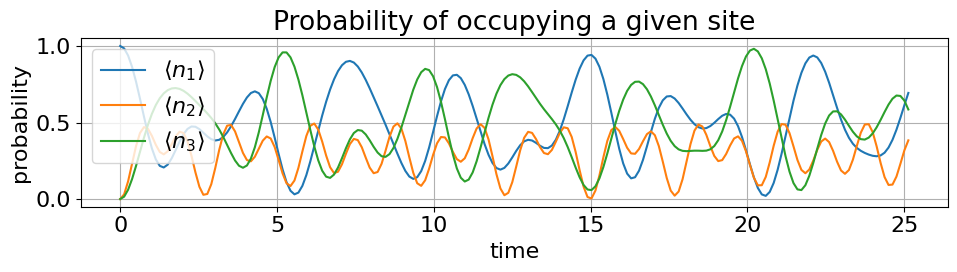

In [99]:
# Plot the time evolution
# list of labels for the plot
num_op_labels = [r"$\langle n_" + str(i+1) + "\\rangle$" for i in range(num_sites)]
path = base_path + "3-site-prob.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, n_evo_matrix)
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

#### Particle and parity conservation check

It's always a good idea to test if a computer is giving something that makes sense. One such test, and a rather low effort one, is to compute the probability of finding the particle across all sites at each time point. Since we know there is only one particle to begin with and particle number is conserved, we should calculate 1 for all time steps. We will later use this fact in post-processing our quantum computer data by throwing out any measurements that don't preserve particle number.

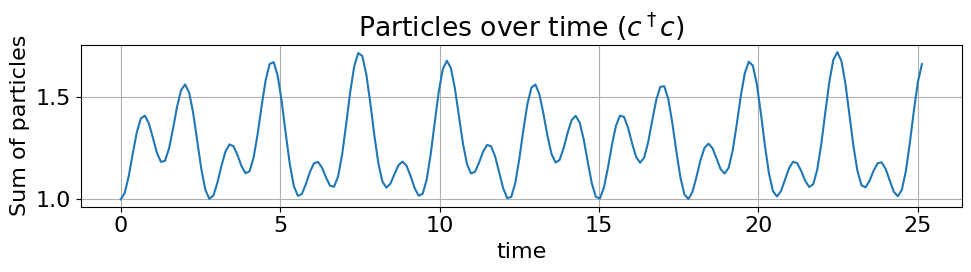

In [100]:
path = base_path + "3-site-particle-count.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, np.sum(n_evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("Sum of particles")
plt.title("Particles over time ($c^\dagger c$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

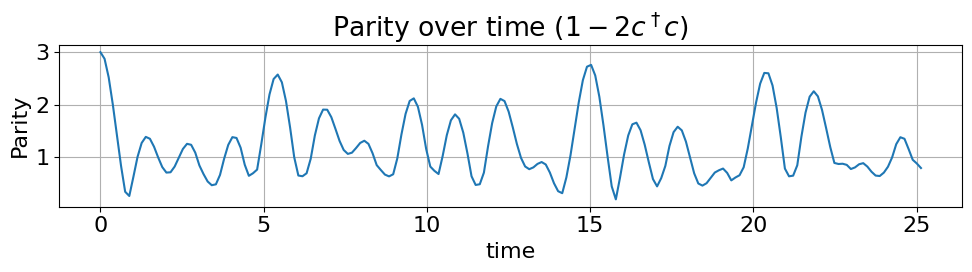

In [101]:
path = base_path + "3-site-parity-count.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, np.sum(p_evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("Parity")
plt.title(r"Parity over time ($1-2c^\dagger c$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

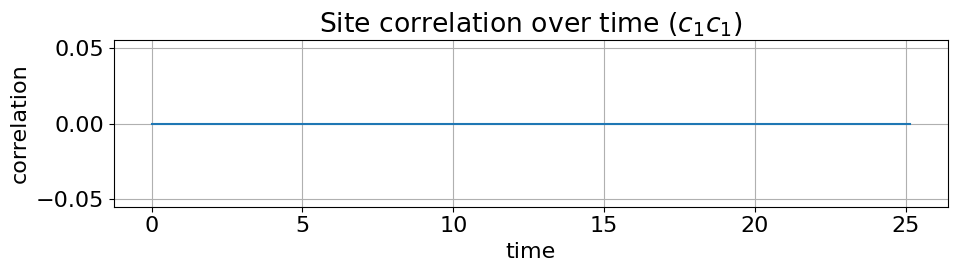

In [102]:
path = base_path + "3-site-corr_nb_11.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, np.sum(cc_nb_evo_matrix_00, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_1$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

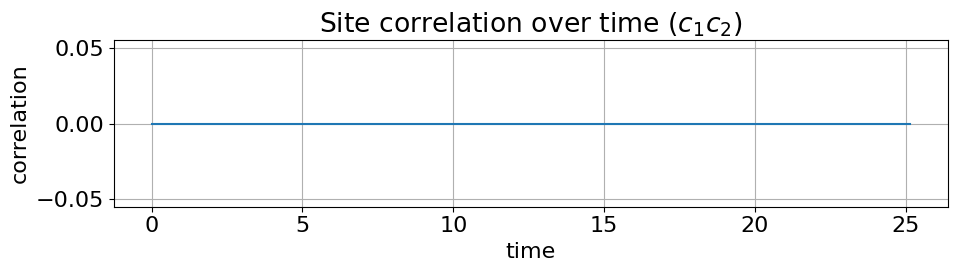

In [103]:
path = base_path + "3-site-corr_nb_12.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, np.sum(cc_nb_evo_matrix_00, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_2$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

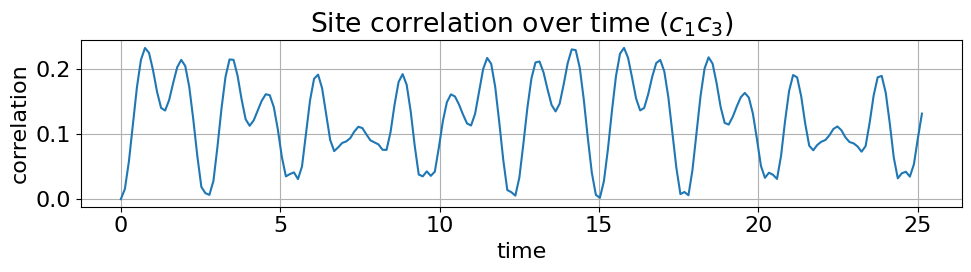

In [104]:
path = base_path + "3-site-corr-edge.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, np.sum(cc_edge_evo_matrix_02, axis=1))
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Site correlation over time ($c_1 c_3$)")
plt.grid()
plt.tight_layout()
plt.savefig(path)
plt.show()

### Trotterization

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:25<00:00,  8.61s/it]


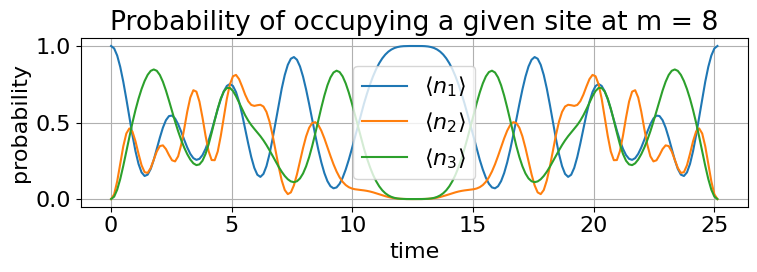

In [105]:
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution

# Number of trotter steps
trotter_steps = 8

# Calculate each number operator's expectation value at each time point and store in a 2D array
n_evo_matrix_trot = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps)

# Plot the time evolution
path = base_path + "3-site-prob-trotter.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, n_evo_matrix_trot)
plt.xlabel("time")
plt.ylabel("probability")
plt.title(f"Probability of occupying a given site at m = {trotter_steps}")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

### Trotter error

In [106]:
# Number of trotter steps
trotter_steps_1 = 10

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_1)

# Number of trotter steps
trotter_steps_2 = 20
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)

100%|██████████| 3/3 [01:07<00:00, 22.36s/it]


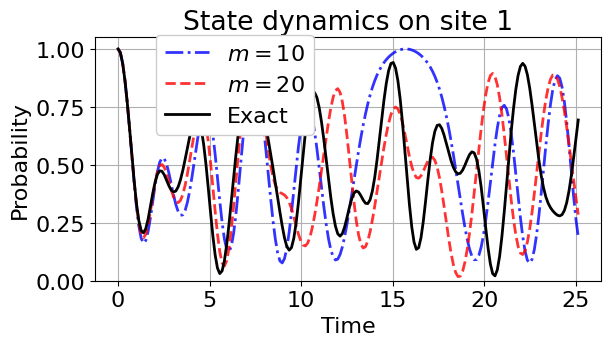

In [107]:
# Plot state dynamics over one particular site
site = 0
path = base_path + "3-site-state_dynm_site1.pdf"

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_2[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_2}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, n_evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.savefig(path)
plt.show()

In [108]:
# Number of trotter steps
trotter_steps_error_1 = 10
trotter_steps_error_2 = 25
trotter_steps_error_3 = 50
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_1)
evo_matrix_trot_error_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_2)
evo_matrix_trot_error_3 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_3)

100%|██████████| 3/3 [02:38<00:00, 52.68s/it]


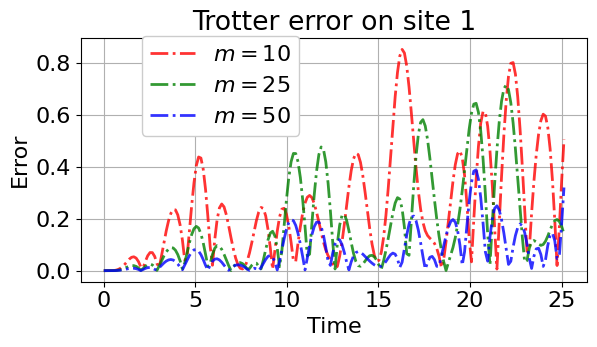

In [109]:
# Plot state dynamics over one particular site
site = 0
path = base_path + "3-site-trotter_error_site1.pdf"

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    np.abs(n_evo_matrix[:, site]-evo_matrix_trot_error_1[:, site]),
    "r-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_1}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix[:, site]-evo_matrix_trot_error_2[:, site]),
    "g-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_2}$",
    markerfacecolor="seagreen",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix[:, site]-evo_matrix_trot_error_3[:, site]),
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_3}$",
    markerfacecolor="darkorange",
    alpha=0.8,
)

plt.xlabel("Time")
plt.ylabel("Error")
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.title("Trotter error on site " + str(site+1))
plt.tight_layout()
plt.savefig(path)
plt.show()

### Generate circuit diagram

In [110]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [111]:
from functions import compute_U_trot
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/3-site-circuit.tex", "w") as f:
    f.write(latex_code)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{2}{\mathrm{exp(it\,III)}}_<<<{0} & \multigate{2}{\mathrm{exp(it\,ZII)}}_<<<{0} & \qw & \qw & \multigate{2}{\mathrm{exp(it\,III)}}_<<<{0} & \multigate{2}{\mathrm{exp(it\,IZI)}}_<<<{0} & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{0})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{0} & \multigate{2}{\mathrm{exp(it\,III)}}_<<<{0} & \multigate{2}{\mathrm{exp(it\,IIZ)}}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{exp(it\,III)}}_<<<{1} & \ghost{\mathrm{exp(it\,ZII)}}_<<<{1} & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{0})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{0} & \ghost{\mathrm{exp(it\,III)}}_<<<{1} & \ghost{\mathrm{exp(it\,IZI)}}_<<<{1} & \ghost{\mathrm{R_{YY}}\,(\mathrm{0})}_<<<{1} & \ghost{\ma